# Market States approach

- From the observations that with tabular models (gradient boosting ensemble),
shuffling the data guarantees no overfitting 
while splitting with chronological order overfits / does not capture the test probability distribution, 
it seems like a time-series approach is necessary :
timestamps are not independant draws of one underlying random variable.
- Defining some latent state of the time-series is expected to be an improvement,
- Also possible to cluster the timesteps into market modes, then to fit a predictor for each market mode.
- Market modes can be defined from the covariance matrix of the features
- Covariance matrix filtering techniques to reduce noise 

In [ ]:
import os
import numpy as np
import pandas as pd
import polars as pl
from typing import List
from pathlib import Path
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

for dirname, _, filenames in os.walk("/kaggle/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

KAGGLE = False  # define paths accordingly
SUBMISSION = False  # use smaller datasets during dev

if KAGGLE:
    crypto_folder = Path("/kaggle/input/drw-crypto-market-prediction")
else:
    crypto_folder = Path("../raw_data/crypto")

## Helper functions

In [ ]:
def get_clean_crypto_data(train: bool = True) -> pl.LazyFrame:
    """
    Load and clean crypto data, returning either train or test set.

    Args:
        train: If True, return training set. If False, return test set.

    Returns:
        Cleaned lazy frame with columns that have variance and no infinite values.
    """

    filename = "train.parquet" if train else "test.parquet"

    # load data
    crypto_lazy = pl.scan_parquet(crypto_folder / filename)
    n_cols = len(crypto_lazy.collect_schema().names())

    if train and KAGGLE:
        # rename timestamp column
        crypto_lazy = crypto_lazy.with_columns(
            pl.col("__index_level_0__").alias("timestamp")
        ).drop(["__index_level_0__"])

    # Remove columns with zero variance in the training set
    train_lazy = pl.scan_parquet(crypto_folder / "train.parquet")
    if KAGGLE:
        train_lazy = train_lazy.with_columns(
            pl.col("__index_level_0__").alias("timestamp")
        ).drop(["__index_level_0__"])

    # Get column names and calculate variance on training set (for consistency)
    crypto_var = train_lazy.select(pl.exclude(["timestamp"]).var())

    crypto_var_cols = (
        crypto_var.select(pl.all() == 0.0)
        .first()
        .collect()
        .to_pandas()
        .T.rename(columns={0: "is_variance_null"})
        .reset_index()
        .rename(columns={"index": "column_name"})
        .groupby("is_variance_null")["column_name"]
        .unique()
    )

    crypto_cols_with_var = crypto_var_cols[False]

    try:
        cols_no_var = crypto_var_cols[True]
        print(f"Columns with no variance : {cols_no_var}")
    except KeyError:
        print("All columns have variance in the train set")

    # remove columns that have no variance in the training set
    train_lazy = train_lazy.select(
        ["timestamp"] + [pl.col(c) for c in crypto_cols_with_var]
    )

    # Remove columns with infinite values (check on training set)
    current_columns = train_lazy.collect_schema().names()
    contains_infinite_cols = (
        train_lazy.select(pl.exclude("timestamp").abs().max().is_infinite())
        .collect()
        .to_pandas()
        .T.rename(columns={0: "contains_infinite"})
        .reset_index()
        .rename(columns={"index": "column_name"})
        .groupby("contains_infinite")["column_name"]
        .unique()
    )

    try:
        cols_with_inf_vals = contains_infinite_cols[True]
        print(f"Columns with infinite values : {cols_with_inf_vals}")
    except KeyError:
        print("No columns with infinite values")

    if not train:
        # add dummy timestamps
        crypto_lazy = crypto_lazy.with_columns(
            ID=range(1, crypto_lazy.select(pl.len()).collect().item() + 1)
        )
    # Filter clean columns based on what's available in the current dataset
    clean_columns = [
        c for c in current_columns if c in contains_infinite_cols[False]
    ] + ["timestamp", "ID"]
    available_columns = crypto_lazy.collect_schema().names()
    final_columns = [c for c in clean_columns if c in available_columns]
    print(f"Eventually {len(final_columns)}, removed {n_cols - len(final_columns)}")

    return crypto_lazy.select(final_columns)


def get_diff_features(df: pl.LazyFrame, stats_columns: List[str]):
    return (
        df.with_columns(pl.exclude(stats_columns).diff())
        .with_row_index()
        .fill_null(strategy="backward")
        .select(pl.exclude("index"))
    )


def get_ma_features(df: pl.LazyFrame, cols: List[str]):
    return df.with_columns(pl.col(cols).rolling_mean(window_size=23, min_samples=1))


def get_rolling_var(df: pl.LazyFrame, cols: List[str]):
    return df.with_columns(pl.col(cols).rolling_var(window_size=23, min_samples=1))

## Metadata

In [ ]:
stats_columns = [
    "timestamp",
    "bid_qty",
    "ask_qty",
    "buy_qty",
    "sell_qty",
    "volume",
    "label",
]
stats_columns_test = [
    "ID",
    "bid_qty",
    "ask_qty",
    "buy_qty",
    "sell_qty",
    "volume",
    "label",
]
X_exclude = ["timestamp", "label"]
X_test_exclude = ["ID", "label"]

## Load data

In [ ]:
# create intermediate clean file
crypto_lazy_clean = get_clean_crypto_data(train=True)

In [ ]:
# transform the dataset to day columns and only X features

crypto_df = crypto_lazy_clean.select(pl.exclude(stats_columns)).collect().to_pandas().T
crypto_df.to_parquet("features.parquet")
del crypto_df

In [ ]:
features_lazy.collect_schema().names()[-10:]

In [ ]:
features_lazy.collect_schema().names()[:10]

In [ ]:
features_lazy = pl.scan_parquet("features.parquet").drop("__index_level_0__")
cols = features_lazy.collect_schema().names()
features_lazy = features_lazy.select(pl.col(cols[:200]))
n = len(features_lazy.collect_schema().names())
lazy_cor = pl.concat(
    [
        features_lazy.select(pl.corr(pl.all(), pl.col(f"{i}"))).collect()
        for i in range(n)
    ]
)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,…,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,0.853176,0.744728,0.824992,0.797097,0.814193,0.743647,0.627196,0.578635,0.758636,0.532042,0.728936,0.823151,0.832906,0.777549,0.687225,0.716489,0.773195,0.757653,0.711555,0.762342,0.756749,0.765367,0.725226,0.635637,0.726486,0.552151,0.736694,0.69096,0.613674,0.615818,0.778944,0.751962,0.759682,0.729877,0.737666,0.689867,…,0.365626,0.38936,0.283597,0.371796,0.330266,0.283475,0.327092,0.327403,0.356978,0.304093,0.353264,0.354264,0.333768,0.291909,0.358598,0.321753,0.34169,0.306487,0.218954,0.197185,0.288001,0.29964,0.339307,0.273063,0.313743,0.280028,0.179842,0.151967,0.157934,0.323582,0.359071,0.441119,0.373752,0.266706,0.165791,0.218778,0.177893
0.853176,1.0,0.951233,0.930107,0.945403,0.824902,0.769246,0.696277,0.662138,0.815326,0.675829,0.761407,0.851873,0.83173,0.899682,0.816309,0.824553,0.816872,0.755299,0.655779,0.72592,0.731722,0.731542,0.761338,0.721203,0.7126,0.679327,0.749511,0.732046,0.635743,0.643293,0.717085,0.713848,0.764417,0.711062,0.724512,0.703223,…,0.419337,0.406049,0.399439,0.382501,0.366719,0.349535,0.378761,0.370074,0.392847,0.376558,0.404083,0.375928,0.380657,0.375097,0.407476,0.390425,0.354196,0.35721,0.334781,0.296676,0.318077,0.35865,0.340315,0.332151,0.303494,0.307613,0.271994,0.231404,0.229469,0.345524,0.387244,0.320169,0.308005,0.238852,0.210918,0.239189,0.219384
0.744728,0.951233,1.0,0.885295,0.913834,0.730424,0.715521,0.697212,0.711475,0.824565,0.746694,0.770658,0.828365,0.745837,0.858635,0.805669,0.808545,0.762995,0.689543,0.589834,0.658963,0.678074,0.663824,0.718132,0.738562,0.668738,0.730315,0.728454,0.729777,0.654262,0.667277,0.671802,0.662191,0.717769,0.675148,0.693562,0.69322,…,0.405958,0.364878,0.41217,0.358626,0.358083,0.369925,0.38877,0.385872,0.389191,0.388496,0.399922,0.354004,0.375166,0.399312,0.401474,0.385674,0.317398,0.333427,0.363212,0.338732,0.324031,0.37006,0.312275,0.322916,0.251493,0.268725,0.295054,0.282908,0.291922,0.343052,0.365825,0.198145,0.176892,0.160964,0.186811,0.192294,0.190861
0.824992,0.930107,0.885295,1.0,0.969308,0.899132,0.761625,0.62481,0.560762,0.784206,0.557872,0.70607,0.833515,0.925534,0.936797,0.823918,0.848637,0.84233,0.778495,0.647239,0.739853,0.728888,0.762687,0.771891,0.697383,0.780113,0.618523,0.776944,0.709506,0.574269,0.577238,0.733178,0.737496,0.778113,0.705795,0.704023,0.663931,…,0.441585,0.483144,0.38,0.44946,0.40833,0.354282,0.387071,0.370945,0.445492,0.373819,0.417217,0.430122,0.408181,0.38454,0.449271,0.423068,0.430782,0.404115,0.328458,0.276398,0.345513,0.363422,0.413135,0.339576,0.391393,0.358368,0.274655,0.201093,0.176531,0.349199,0.397256,0.457044,0.414555,0.326705,0.26055,0.322352,0.277871
0.797097,0.945403,0.913834,0.969308,1.0,0.893884,0.834023,0.741269,0.661703,0.805149,0.637623,0.722535,0.821589,0.862765,0.940834,0.863387,0.871263,0.865375,0.815209,0.713752,0.787154,0.786319,0.794971,0.826595,0.784055,0.787006,0.717367,0.791257,0.76585,0.658564,0.643455,0.721398,0.738455,0.794879,0.74431,0.753238,0.722568,…,0.459209,0.468372,0.44218,0.441786,0.435923,0.405845,0.422824,0.405226,0.439868,0.406576,0.429124,0.426558,0.431825,0.411251,0.444493,0.430578,0.414662,0.425633,0.380803,0.326008,0.349324,0.384798,0.3832,0.36669,0.37264,0.378142,0.335134,0.266668,0.233727,0.348876,0.397686,0.378704,0.3765,0.323796,0.313587,0.343836,0.328537
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.373752,0.308005,0.

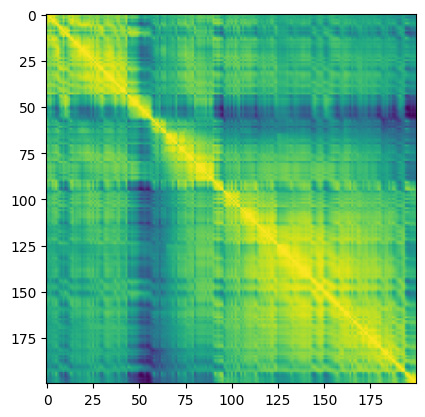

In [15]:
from matplotlib import pyplot as plt

plt.imshow(lazy_cor.to_numpy())

In [16]:
adjacency = 1.0 - lazy_cor.to_numpy()

adjacency

array([[0.        , 0.14682444, 0.25527248, ..., 0.83420903, 0.78122206,
        0.8221072 ],
       [0.14682444, 0.        , 0.04876749, ..., 0.78908152, 0.76081121,
        0.7806163 ],
       [0.25527248, 0.04876749, 0.        , ..., 0.81318917, 0.80770625,
        0.80913916],
       ...,
       [0.83420903, 0.78908152, 0.81318917, ..., 0.        , 0.03670588,
        0.04021569],
       [0.78122206, 0.76081121, 0.80770625, ..., 0.03670588, 0.        ,
        0.02693734],
       [0.8221072 , 0.7806163 , 0.80913916, ..., 0.04021569, 0.02693734,
        0.        ]], shape=(200, 200))

In [17]:
np.save("adjancency_matrix.npy", adjacency)

## Filter covariance matrix between features

In [ ]:
n_samples = 50_000
cov = crypto[[c for c in cols if c not in stats_columns]].sample(n_samples).cov()
from matplotlib import pyplot as plt

plt.imshow(cov)

In [ ]:
cor = crypto[[c for c in cols if c not in stats_columns]].sample(n_samples).corr()
plt.imshow(cor)

In [ ]:
svd = np.linalg.svd(cov.values, hermitian=True)
U, S = svd.U, svd.S

In [ ]:
_, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(len(S)), S)
ax.set_yscale("log")
ax.axhline(0.1, c="red", linestyle="--")
ax.grid()

In [ ]:
cov_clean = U @ np.diag(np.where(S > 1.0, S, np.zeros_like(S))) @ U.T

plt.imshow(cov_clean)

## Compute day-wise covariance matrix to cluster timestamps into market modes

### Compute Louvain network communities and plot graph

In [ ]:
from IPython.display import SVG
from sknetwork.data import karate_club, painters, movie_actor
from sknetwork.clustering import Louvain, get_modularity
from sknetwork.linalg import normalize
from sknetwork.utils import get_membership
from sknetwork.visualization import visualize_graph, visualize_bigraph
from scipy.sparse import csr_matrix

adjacency_np = np.load("adjancency_matrix.npy")
adjacency = csr_matrix(adjacency_np)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 39800 stored elements and shape (200, 200)>

In [19]:
louvain = Louvain()
labels = louvain.fit_predict(adjacency)

In [20]:
labels_unique, counts = np.unique(labels, return_counts=True)
print(labels_unique, counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [30 18 18 16 16 14 13 12 12 10  9  7  6  4  3  3  3  2  2  2]


In [ ]:
k = len(labels_unique)
cx = np.random.randn(2 * k) * 10
cx = cx.reshape((k, 2))

200

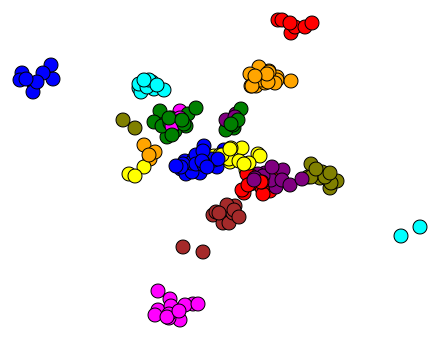

In [26]:
# position = np.random.randn(400).reshape((200, 2))
position = np.array([cx[l] for l in labels]) + np.random.randn(400).reshape((200, 2))
image = visualize_graph(adjacency, position, labels=labels, display_edges=False)
SVG(image)

In [30]:
from sklearn.metrics import silhouette_score

silhouette_score(features_lazy.collect().to_numpy().T, labels=labels)

-0.20100969862569307

### Compute estimated transition matrix

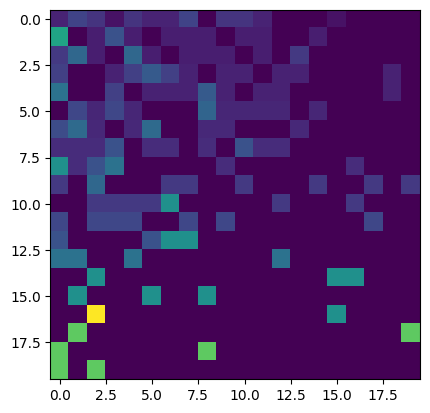

In [37]:
transitions = np.zeros((k, k), dtype=np.float64)
for l_prev, l in zip(labels[:-1], labels[1:]):
    transitions[l_prev, l] += 1.0
transitions = transitions / np.sum(transitions, axis=1)[:, None]
plt.imshow(transitions)

- train a classifier to distinguish market modes
    - PCA to define relevant samples for each modes, then KNN to classify new samples
    - need train data classification guarantees, otherwise market mode feature will be very lossy

## Compute adjacency matrix

## Apply Louvain clustering algorithm of community detection

In [ ]:
X = crypto_lazy_clean.select(pl.exclude(X_exclude)).collect().to_numpy()
y = crypto_lazy_clean.select(pl.col("label")).collect().to_numpy().T[0]

if not SUBMISSION:
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        shuffle=False,  # TODO : question this, whether timestamps are independant draws
        random_state=42,
    )
else:
    X_train, y_train = X, y
del X
del y

## Train model

In [ ]:
lr = 1.0

lin = RandomForestRegressor(
    # fit_intercept=True,
    n_estimators=80,
    n_jobs=-1,
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    max_features="sqrt",
    max_samples=0.5,
    random_state=41,
)
# n_samples = 80_000
lin.fit(
    X_train,
    y_train,
    # sample_weight=np.flip(1.0 / np.sqrt(np.arange(1, n_samples+1)))
)

y_train_lin = lin.predict(X_train)

print(f"R2 train lin: {r2_score(y_train, y_train_lin)}")
print(f"Pearson train lin : {pearsonr(y_train, y_train_lin)}")

y_train_res = y_train - lr * y_train_lin


lgb_model = lgb.LGBMRegressor(
    random_state=42,
    # weight=np.flip(1.0 / np.sqrt(np.arange(1, len(X_train)+1))),
    # n_estimators=80,
    # max_depth=10,
    n_jobs=-1,
)
lgb_model.fit(X_train, y_train_res)

y_train_hat = lgb_model.predict(X_train)

print(f"R2 train : {r2_score(y_train, y_train_hat + lr * y_train_lin)}")
print(f"Pearson train : {pearsonr(y_train, y_train_hat + lr * y_train_lin)}")

if not SUBMISSION:
    y_test_lin = lin.predict(X_test)

    print(f"R2 test lin : {r2_score(y_test, y_test_lin)}")
    print(f"Pearson test lin : {pearsonr(y_test, y_test_lin)}")

    y_test_hat = lgb_model.predict(X_test)

    print(f"R2 test : {r2_score(y_test, y_test_hat + lr * y_test_lin)}")
    print(f"Pearson test : {pearsonr(y_test, y_test_hat + lr * y_test_lin)}")

## Load test data

In [ ]:
crypto_lazy_test = get_clean_crypto_data(train=False)

# create unique row identifier
n = crypto_lazy_test.select(pl.len()).collect().item()
crypto_lazy_test = crypto_lazy_test.with_columns(ID=range(1, n + 1))

print(crypto_lazy_test.select(pl.len()).collect().item())

crypto_lazy_test = crypto_lazy_test.join(
    get_diff_features(crypto_lazy_test, stats_columns_test),
    on=stats_columns_test,
    how="inner",
    suffix="_diff",
)

# crypto_lazy_test = get_diff_features(crypto_lazy_test, stats_columns_test)
assert n == crypto_lazy_test.select(pl.len()).collect().item()

## Predict target \& submit

In [ ]:
X_test = crypto_lazy_test.select(pl.exclude(X_test_exclude)).collect().to_numpy()
y_lin_test = lin.predict(X_test)
y_hat_lgb_test = lgb_model.predict(X_test)

del X_test

In [ ]:
crypto_lazy_test = crypto_lazy_test.with_columns(
    ID=range(1, n + 1), prediction=y_hat_lgb_test + lr * y_lin_test
)
crypto_lazy_test.head(5).collect()
crypto_lazy_test.select([pl.col("ID"), pl.col("prediction")]).collect().write_csv(
    Path("submission.csv")
)